In [1]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seaborn as sns
import xarray as xr
#import palettes

In [2]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [3]:
# Load output
spec_febTS = xr.open_dataset('../curtain_SSH_spectra_febTS.nc')
X_spec = spec_febTS.X

ssh_febTS = xr.open_dataset('../curtain_SSH_SVB_febTS.nc')
ssh_febTS_NoB = xr.open_dataset('../curtain_SSH_NoSVB_febTS.nc')
X_ssh = ssh_febTS.X

spec_baro = xr.open_dataset('../curtain_SSH_spectra_barotropic.nc')
X = spec_baro.X

ssh_baro = xr.open_dataset('../curtain_SSH_SVB_Barotropic.nc')
ssh_baro_NoB = xr.open_dataset('../curtain_SSH_NoSVB_Barotropic.nc')

In [4]:
# Get coastline points
df = pd.read_csv('../coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

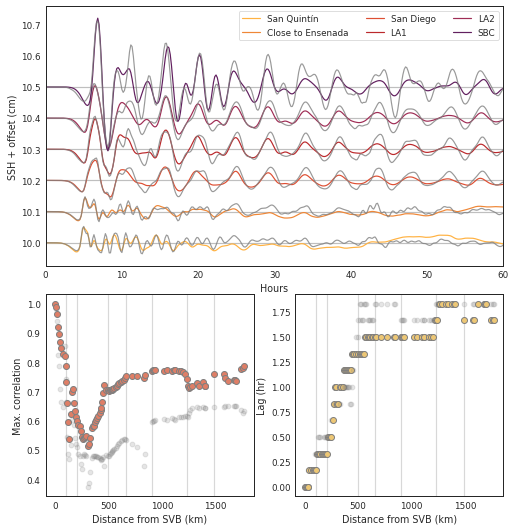

In [5]:
sns.set_context('paper')
sns.set_style('white')

time = np.arange(0,720)*600
colors=[ "#df7e66", "#94b594", "#224b5e","#b75347",]
colors2=("#ffd353", "#ffb242", "#ef8737", "#de4f33", "#bb292c", "#9f2d55", "#62205f", "#341648")

fig = plt.figure(figsize=(7.48,8))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05,bottom=0.5, top=0.95, wspace=0.05, hspace=0.2)
ax1 = plt.subplot(gs1[0,0])
offset=0

gs2 = gridspec.GridSpec(1, 2, wspace=0.2)
gs2.update(left=0.05,bottom=0.1, top=0.45, hspace=0.05)
ax2 = plt.subplot(gs2[0,0])
ax3 = plt.subplot(gs2[0,1])

# ---- lagged- cross-correlations
kk1 = 0
nt = 144 # one-day long time series
dx = 10

for kk, lab in zip([47,100,230,307,335,400,450], 
                   ['San Quintín','Close to Ensenada','San Diego','LA1','LA2','SBC1','SBC2']):
    ax2.axvline(ssh_febTS.X[kk], color='0.7', alpha=0.5)
    ax3.axvline(ssh_febTS.X[kk], color='0.7', alpha=0.5)
    
for kk2 in range(0,500,5):
    ssh1 = (ssh_febTS.curtain_data[:nt,kk1]-ssh_febTS_NoB.curtain_data[:nt,kk1]).data
    df1 = pd.DataFrame({'time':ssh_febTS.T[:nt].data, 
                       'ssh':ssh1})
    ssh2 = (ssh_febTS.curtain_data[:nt,kk2]-ssh_febTS_NoB.curtain_data[:nt,kk2]).data
    df2 = pd.DataFrame({'time':ssh_febTS.T[:nt].data, 
                       'ssh':ssh2})

    
    ssh1b = (ssh_baro.curtain_data[:nt,kk1]-ssh_baro_NoB.curtain_data[:nt,kk1]).data
    df1b = pd.DataFrame({'time':ssh_baro.T[:nt].data, 
                       'ssh':ssh1b})
    ssh2b = (ssh_baro.curtain_data[:nt,kk2]-ssh_baro_NoB.curtain_data[:nt,kk2]).data
    df2b = pd.DataFrame({'time':ssh_baro.T[:nt].data, 
                       'ssh':ssh2b})
    d1 = df1.ssh
    d2 = df2.ssh
    d1b = df1b.ssh
    d2b = df2b.ssh
    periods = nt/4

    rs = [crosscorr(d1, d2, lag) for lag in range(-int(periods),int(periods))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    
    rsb = [crosscorr(d1b, d2b, lag) for lag in range(-int(periods),int(periods))]
    offsetb = np.floor(len(rsb)/2)-np.argmax(rsb)

   
    ax2.plot(ssh_baro.X[kk2],np.nanmax(rsb),'o', markeredgecolor='0.5', color="0.5", alpha=0.2)
    ax3.plot(ssh_baro.X[kk2],(offsetb*600)/3600, 'o', markeredgecolor='0.5', color="0.5", alpha=0.2)
    ax2.plot(ssh_febTS.X[kk2],np.nanmax(rs),'o', markersize=6, markeredgecolor="0.5", color="#df7e66")
    ax3.plot(ssh_febTS.X[kk2],(offset*600)/3600, 'o', markersize=6,markeredgecolor="0.5", color="#edc775")

ax2.set_xlabel('Distance from SVB (km)')
ax3.set_xlabel('Distance from SVB (km)')
ax2.set_ylabel('Max. correlation')
ax3.set_ylabel('Lag (hr)')
ax2.tick_params(axis='both', which='major', pad=0)
ax3.tick_params(axis='both', which='major', pad=0)

# ---- time series --------------

for kk, lab, col in zip([47,100,230,307,335,440], 
                   ['San Quintín', 'Close to Ensenada','San Diego','LA1','LA2','SBC'], colors2[1:]):
    eta = 100*(ssh_febTS.curtain_data[:,kk]-ssh_febTS_NoB.curtain_data[:,kk])+offset
    etab = 100*(ssh_baro.curtain_data[:,kk]-ssh_baro_NoB.curtain_data[:,kk])+offset
    ax1.axhline(offset, color='0.5', alpha=0.5)
    ax1.plot(ssh_febTS.T/3600,eta, label=lab , alpha=1, color=col)
    ax1.plot(ssh_baro.T/3600,etab , alpha=0.8, color='0.5')
    offset = offset + 0.1
ax1.set_xlim(0,24*2.5)
ax1.tick_params(axis='both', which='major', pad=0)  
ax1.legend(ncol=3)
ax1.set_ylabel('SSH + offset (cm)')
ax1.set_xlabel('Hours')
# --------------------------------


plt.savefig('figure4.png', dpi=500, bbox_inches='tight')

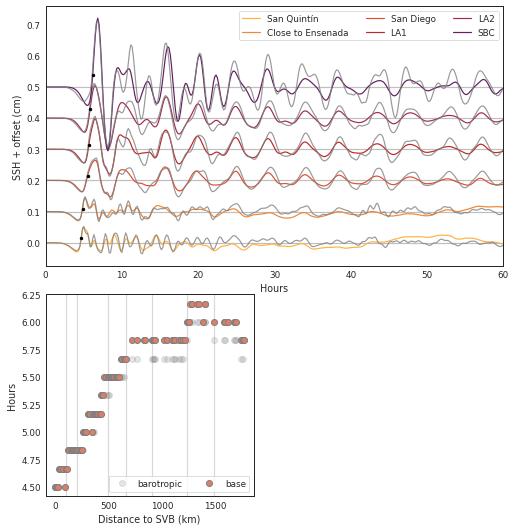

In [45]:
sns.set_context('paper')
sns.set_style('white')

time = np.arange(0,720)*600
colors=[ "#df7e66", "#94b594", "#224b5e","#b75347",]
colors2=("#ffd353", "#ffb242", "#ef8737", "#de4f33", "#bb292c", "#9f2d55", "#62205f", "#341648")

fig = plt.figure(figsize=(7.48,8))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05,bottom=0.5, top=0.95, wspace=0.05, hspace=0.2)
ax1 = plt.subplot(gs1[0,0])
offset=0

gs2 = gridspec.GridSpec(1, 2, wspace=0.2)
gs2.update(left=0.05,bottom=0.1, top=0.45, hspace=0.05)
ax2 = plt.subplot(gs2[0,0])

kk1 = 0
nt = 45 # end time index of the section where we look for zero-xing
n0 = 25
dx = 10

for kk, lab in zip([47,100,230,307,335,400,450], 
                   ['San Quintín','Close to Ensenada','San Diego','LA1','LA2','SBC1','SBC2']):
    ax2.axvline(ssh_febTS.X[kk], color='0.7', alpha=0.5)
    
# ---- arrival(?) time of first zero-crossing --------------
zeroxing = np.empty(100)
zeroxing_baro = np.empty(100)
jj=0
for kk in range(0,500,5):   
    eta = 100*(ssh_febTS.curtain_data[n0:nt,kk]-ssh_febTS_NoB.curtain_data[n0:nt,kk])
    etab = 100*(ssh_baro.curtain_data[n0:nt,kk]-ssh_baro_NoB.curtain_data[n0:nt,kk])
    
    for ssh, ii in zip(eta, range(len(eta))):
        if ssh < 0:
            continue
        else:
            zeroxing[jj] = ssh_febTS.T[ii+n0]/3600
            break    
    for sshb, ii in zip(etab, range(len(eta))):        
        if sshb < 0:
            continue          
        else:
            zeroxing_baro[jj] = ssh_baro.T[ii+n0]/3600
            break
    jj=jj+1
    
ax2.plot(ssh_baro.X[0:500:5],zeroxing_baro,'o', alpha=0.2, 
         color='0.5', markersize=6,label='barotropic')
ax2.plot(ssh_febTS.X[0:500:5],zeroxing,'o', label='base',
         markeredgecolor='0.5',color="#df7e66", markersize=6)
ax2.tick_params(axis='both', which='major', pad=0)  
ax2.legend(ncol=3)
ax2.set_ylabel('Hours')
ax2.set_xlabel('Distance to SVB (km)')

    
# ---- time series --------------

for kk, lab, col in zip([47,100,230,307,335,440], 
                   ['San Quintín', 'Close to Ensenada','San Diego','LA1','LA2','SBC'], colors2[1:]):
    eta = 100*(ssh_febTS.curtain_data[:,kk]-ssh_febTS_NoB.curtain_data[:,kk])+offset
    etab = 100*(ssh_baro.curtain_data[:,kk]-ssh_baro_NoB.curtain_data[:,kk])+offset
    ax1.axhline(offset, color='0.5', alpha=0.5)
    ax1.plot(ssh_febTS.T/3600,eta, label=lab , alpha=1, color=col)
    ax1.plot(ssh_baro.T/3600,etab , alpha=0.8, color='0.5')
#    ax1.axvline(3.5)
#    ax1.axvline(ssh_febTS.T[45]/3600, color='r')
    
    eta = 100*(ssh_febTS.curtain_data[n0:nt,kk]-ssh_febTS_NoB.curtain_data[n0:nt,kk])+offset    
    for ssh, ii in zip(eta, range(len(eta))):
        if ssh-offset < 0:
            continue
        else:
            ax1.plot(ssh_febTS.T[ii+n0]/3600,ssh, 'k.')
            
            break
    offset = offset + 0.1
     
ax1.set_xlim(0,24*2.5)
ax1.tick_params(axis='both', which='major', pad=0)  
ax1.legend(ncol=3)
ax1.set_ylabel('SSH + offset (cm)')
ax1.set_xlabel('Hours')
# --------------------------------


plt.savefig('figure4_v2.png', dpi=500, bbox_inches='tight')